<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

### Импорт библиотек

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Методы классификации:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Вспомогательные методы:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Методы измерения метрик классифиукаци:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

# import warnings
# warnings.filterwarnings("ignore")

## Подготовка данных

Загрузим данные

In [2]:
df = pd.read_csv('datasets/Churn.csv')

Посмотреим на данные

In [3]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
df.shape

(10000, 14)

In [6]:
df['RowNumber'].nunique()

10000

In [7]:
df['Surname'].value_counts()

Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
            ..
Izmailov     1
Bold         1
Bonham       1
Poninski     1
Burbidge     1
Name: Surname, Length: 2932, dtype: int64

In [8]:
df['Surname'].nunique()

2932

In [9]:
df = df.drop(['CustomerId', 'RowNumber', 'Surname'], axis=1)

In [10]:
df['Geography'].nunique()

3

In [11]:
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [12]:
df['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [13]:
df.isna().sum()

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [14]:
df['Tenure'].mean()

4.997690023099769

<AxesSubplot: >

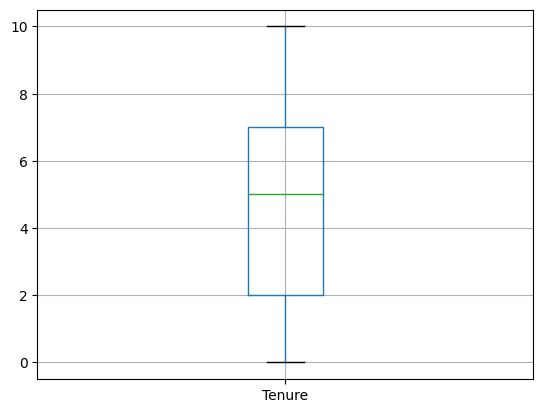

In [15]:
df.boxplot('Tenure')

In [16]:
df['Tenure'].fillna(df['Tenure'].mean(), inplace=True)

Применим кодирование для категориальных признаков. Т.к. в проекте нет порядковых кодегориальных перменных, используем прямое кодирование `pd.get_dummies`.<br>
Сохраним данные в переменную `dfd` – DataFrame dummied

In [17]:
dfd = pd.get_dummies(df, drop_first=True)

In [18]:
target = dfd['Exited']
features =dfd.drop('Exited', axis=1)
train_features, valid_features, train_target, valid_target = train_test_split(features, target, test_size=0.25, random_state=12345) 

### Стандартизация (Масштабирование)

In [19]:
dfd.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0


In [20]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance',  'NumOfProducts', 'EstimatedSalary']

In [21]:
scaler = StandardScaler()
scaler.fit(train_features[numeric])

train_features[numeric] = scaler.transform(train_features[numeric])
valid_features[numeric] = scaler.transform(valid_features[numeric])

train_features.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
226,0.442805,-0.841274,1.446176,-1.224577,0.817772,1,1,-1.269750,0,0,0
7756,-0.310897,-0.270730,0.719177,0.641783,-0.896874,1,1,0.960396,0,1,0
2065,-0.259274,-0.556002,1.082676,-1.224577,0.817772,1,0,0.661864,0,0,1
2800,1.217157,1.155631,1.446176,1.290462,0.817772,1,0,-1.039476,0,0,1
7028,0.690598,-1.221637,-0.008661,1.142121,-0.896874,0,0,-0.851729,1,0,1


## Исследование задачи

Проверим баланс классов:

In [36]:
target.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Баланс классов заметно смещен в сторону значения `0`. Для начала поробуем построить модели и изучить модели не обращая снимания на дисбаланс

In [23]:
models_chars = {}

### Функции:

In [24]:
def add_model_chars(valid_prediction, valid_target, valid_probabilities, models_type):
    models_chars[models_type] = {
        'accuracy':accuracy_score(valid_prediction, valid_target),
        'recall_score':recall_score(valid_target, valid_prediction),
        'precision_score':precision_score(valid_target, valid_prediction),
        'f1_score':f1_score(valid_target, valid_prediction),
        'auc_roc':roc_auc_score(valid_target, valid_probabilities[:, 1])
    }
    return models_chars[models_type]

In [25]:
def build_graphs(model, valid_features, valid_target, valid_probabilities):
    # valid_probabilities = model.predict_proba(valid_features)
    precision, recall, thresholds = precision_recall_curve(valid_target, valid_probabilities[:, 1])
    fpr, tpr, thresholds = roc_curve(valid_target, valid_probabilities[:, 1]) 

    fig = plt.figure(figsize=(12, 3))
    pr_curve = fig.add_subplot(1, 2, 1)
    roc1_curve = fig.add_subplot(1, 2, 2)

    pr_curve.step(recall, precision, where='post')
    pr_curve.set_xlabel('Recall')
    pr_curve.set_ylabel('Precision')
    pr_curve.set_xlim([0.0, 1.0])
    pr_curve.set_ylim([0.0, 1.0])
    pr_curve.set_title('Кривая Precision-Recall')

    roc1_curve.plot(fpr, tpr)
    roc1_curve.plot([0, 1], [0, 1], linestyle='--')
    roc1_curve.set_xlabel('False Positive Rate')
    roc1_curve.set_ylabel('True Positive Rate')
    roc1_curve.set_xlim([0.0, 1.0])
    roc1_curve.set_ylim([0.0, 1.0])
    roc1_curve.set_title('ROC-кривая')

    return fig.show()

### Логистическая регресски

In [26]:
model =  LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000, class_weight='balanced')
model.fit(train_features, train_target)
valid_prediction = model.predict(valid_features)
valid_probabilities = model.predict_proba(valid_features)

add_model_chars(valid_prediction, valid_target, valid_probabilities, models_type='LogisticRegression')

{'accuracy': 0.7044,
 'recall_score': 0.7046728971962617,
 'precision_score': 0.3935281837160752,
 'f1_score': 0.5050234427327529,
 'auc_roc': 0.7632522413260089}

C:\Users\user\AppData\Local\Temp\ipykernel_6212\3054723639.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  return fig.show()


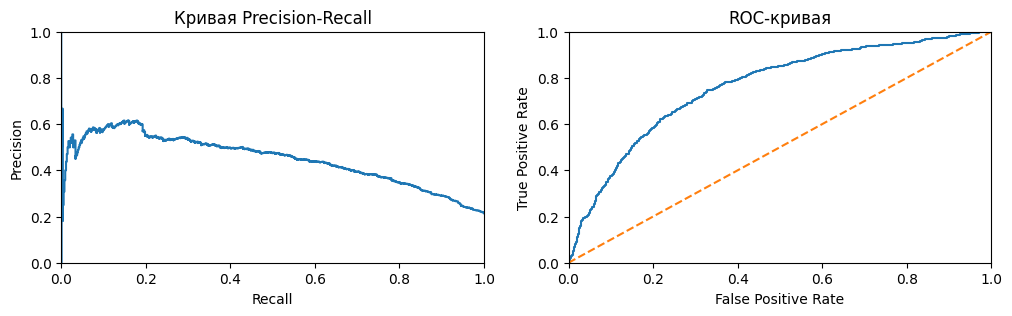

In [27]:
build_graphs(model, valid_features, valid_target, valid_probabilities)

### Дерево решений

In [28]:
best_result = 0

for depth in range(1, 16):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced') # инициализируйте модель DecisionTreeRegressor с параметром random_state=12345 и max_depth=depth
    model.fit(train_features, train_target) # обучите модель на тренировочной выборке
    valid_prediction = model.predict(valid_features) # получите предсказания модели на валидационной выборке
    result =  accuracy_score(valid_prediction, valid_target)
    # print(depth)
    # print('f1_score', f1_score(valid_target, valid_prediction))
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth

print('best accuracy score:', best_result)
print('При depth', best_result)


best accuracy score: 0.8024
При depth 0.8024


In [29]:
%%time
valid_prediction = best_model.predict(valid_features)
valid_probabilities = best_model.predict_proba(valid_features)
add_model_chars(
    valid_prediction, valid_target, valid_probabilities, 'DecisionTreeClassifier')

CPU times: total: 15.6 ms
Wall time: 15 ms


{'accuracy': 0.8024,
 'recall_score': 0.697196261682243,
 'precision_score': 0.5290780141843971,
 'f1_score': 0.6016129032258064,
 'auc_roc': 0.8461211386173932}

C:\Users\user\AppData\Local\Temp\ipykernel_6212\3054723639.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  return fig.show()


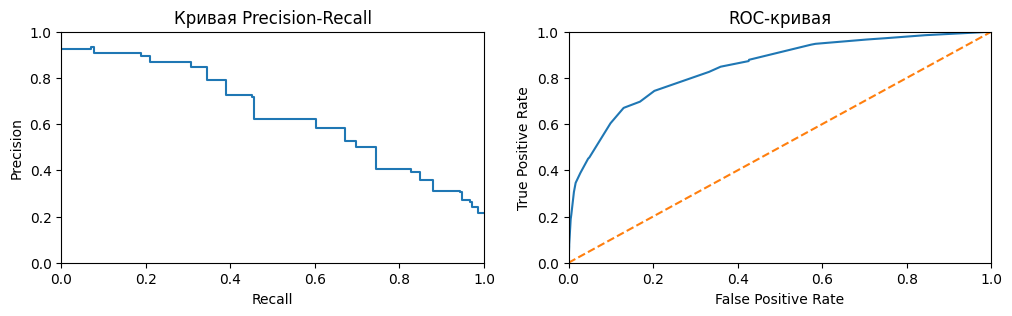

In [30]:
build_graphs(best_model, valid_features, valid_target, valid_probabilities)

### Случайный лес

In [31]:
best_result = 0

for depth in  range(1, 16, 1):
    model = RandomForestClassifier(random_state=12345, n_estimators=3, max_depth=depth, class_weight='balanced')
    model.fit(train_features, train_target) # обучите модель на тренировочной выборке
    valid_prediction = model.predict(valid_features) # получите предсказания модели на валидационной выборке
    result =  accuracy_score(valid_prediction, valid_target)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth

print('best accuracy_score:', best_result)
print('При depth:', best_depth)
print('f1_score', f1_score(valid_target, valid_prediction))

best accuracy_score: 0.8204
При depth: 14
f1_score 0.5515911282545805


In [32]:
best_result = 0

for n_estimators in range(10, 100, 10):
    model = RandomForestClassifier(random_state=12345, n_estimators=n_estimators, max_depth=best_depth)
    model.fit(train_features, train_target) # обучите модель на тренировочной выборке
    valid_prediction = model.predict(valid_features) # получите предсказания модели на валидационной выборке
    result =  accuracy_score(valid_prediction, valid_target)
    # print(n_estimators)
    # print(result)
    if result > best_result:
        best_model = model
        best_result = result
        best_n_estimators = n_estimators
print('best accuracy_score:', best_result)
print('При n_estimators:', n_estimators)   

best accuracy_score: 0.8612
При n_estimators: 90


In [33]:
%%time
valid_prediction = best_model.predict(valid_features)
valid_probabilities = best_model.predict_proba(valid_features)
add_model_chars(valid_prediction, valid_target, valid_probabilities, models_type='RandomForestClassifier')

CPU times: total: 46.9 ms
Wall time: 47.4 ms


{'accuracy': 0.8612,
 'recall_score': 0.4672897196261682,
 'precision_score': 0.8012820512820513,
 'f1_score': 0.5903187721369539,
 'auc_roc': 0.84260017597679}

C:\Users\user\AppData\Local\Temp\ipykernel_6212\3054723639.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  return fig.show()


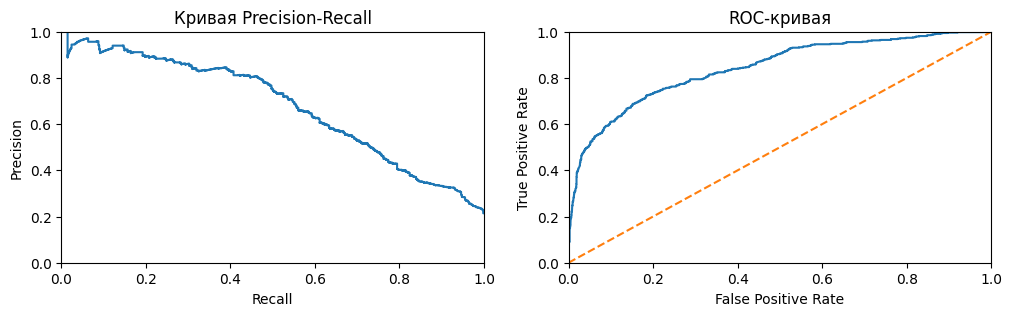

In [34]:
build_graphs(best_model, valid_features, valid_target, valid_probabilities)

In [38]:
pd.DataFrame(models_chars)

,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier
accuracy,0.704400,0.802400,0.861200
recall_score,0.704673,0.697196,0.467290
precision_score,0.393528,0.529078,0.801282
f1_score,0.505023,0.601613,0.590319
auc_roc,0.763252,0.846121,0.842600


## Борьба с дисбалансом

In [37]:
target.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

### Увеличение выборки

In [39]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [46]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [79]:
best_f1_up = 0
best_f1_down = 0
accuracy_scores_up   = []
accuracy_scores_down = []


for repeat in range(1, 50):
    # UP
    features_upsampled, target_upsampled = upsample(train_features, train_target, repeat)
    best_model.fit(features_upsampled, target_upsampled)
    valid_prediction_up = best_model.predict(valid_features)
    f1_up =  f1_score(valid_target, valid_prediction_up)
    accuracy_scores_up.append(f1_up)

    # DOWN
    fraction = 1 / repeat
    features_downsampled, target_downsampled = downsample(features, target, fraction)
    best_model.fit(features_downsampled, target_downsampled)
    valid_prediction_down = best_model.predict(valid_features)
    f1_down = f1_score(valid_target, valid_prediction_down)
    accuracy_scores_down.append(f1_down)

    if f1_up > best_f1_up:
        best_f1_up = f1_up
        best_repeat = repeat

    if f1_down > best_f1_down:
        best_f1_down = f1_down
        best_fraction = fraction


print('best f1_up:', best_f1_up)
print('При repeat:', best_repeat) 
print()
print('best best_f1_down:', best_f1_down)
print('При fraction:', best_fraction) 

best f1_up: 0.6231505657093125
При repeat: 8

best best_f1_down: 0.38936959208899874
При fraction: 0.047619047619047616


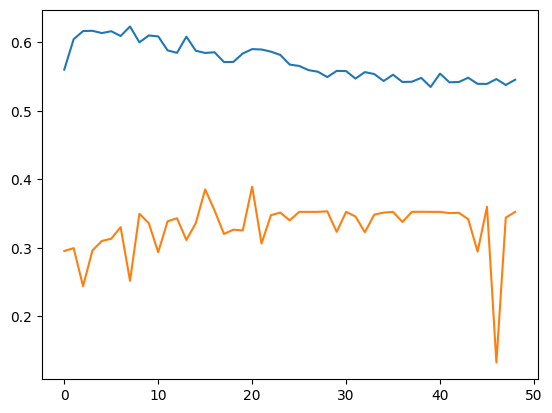

In [80]:
plt.figure()
plt.plot(accuracy_scores_up,  label='UP')
plt.plot(accuracy_scores_down, label='Down')

## Тестирование модели

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*